In [14]:
%pip install -U textblob
!python -m textblob.download_corpora

%pip install nltk

%pip install --upgrade gensim

Note: you may need to restart the kernel to use updated packages.
[nltk_data] Downloading package brown to
[nltk_data]     /Users/yohanismael/nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/yohanismael/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/yohanismael/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/yohanismael/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package conll2000 to
[nltk_data]     /Users/yohanismael/nltk_data...
[nltk_data]   Package conll2000 is already up-to-date!
[nltk_data] Downloading package movie_reviews to
[nltk_data]     /Users/yohanismael/nltk_data...
[nltk_data]   Package movie_reviews is already up-to-date!
Finis

In [15]:
import nltk

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from textblob import TextBlob
from datetime import datetime

import gensim
from gensim.models import Word2Vec

from datetime import datetime

from IPython.display import Markdown, display
string = '# Start'
display(Markdown(string+' Coding'))

# Start Coding

In [16]:
def str_to_timestamp(s):
    out=[]

    s2=str.split(s,'+')
    s3=str.split(s2[0],' ')

    s4=str.split(s3[0],'-')

    s5=str.split(s3[1],':')
    year=int(s4[0])
    month=int(s4[1])
    day=int(s4[2])
    hour=int(s5[0])
    minute=int(s5[1])
    second=int(s5[2])

    return(datetime(year=year,month=month,day=day,hour=hour,minute=minute,second=second).timestamp())

from nltk.tokenize import word_tokenize

def NumStr(mot):
    res = ''.join(filter(lambda i: i.isdigit(), mot))
    if (res==''):
        return False
    return True


def extract_keywords(text):
    # Tokenize the text
    tokens = word_tokenize(text)

    # Apply part-of-speech tagging
    tagged_tokens = nltk.pos_tag(tokens)

    # Select only nouns and adjectives
    keywords = [word for word, pos in tagged_tokens if (pos in ['NN', 'NNS', 'NNP', 'NNPS', 'JJ', 'JJR', 'JJS'] and not NumStr(word))]

    return keywords

def extract_sentiment_polarity(text):
    blob=TextBlob(text)
    return(blob.sentiment.polarity)

In [17]:
data=pd.read_csv('data/minnesota.csv')
df=data
print('start')

df['keywords'] = df['tweet_text'].apply(extract_keywords)

print('end of keywords')

df['sentiment_polarity']=df['tweet_text'].apply(extract_sentiment_polarity)

print('end of polarity')

df['timestamps']=df['tweet_created_dt'].apply(str_to_timestamp)
df['timestamps']=df['timestamps']-df['timestamps'].min()

print('end of timestamps')

clean_data=df

start
end of keywords
end of polarity
end of timestamps


In [28]:
def sliding_window(df,size,sliding):
    X_out=[]

    for time in range(0,int(df['timestamps'].max()),sliding):
        o=df[df.timestamps<time+size]
        X_out.append(o[o.timestamps>time])

        print("%.3f" % (time/int(df['timestamps'].max())), end="\r")
    print("finish")
    return X_out

def dfToListofVectors(df):
    out=[]
    for l_vect in df.vectors:
        for v in l_vect:
            
            out.append(v)
            
    return out

In [29]:
def word2vectors(l):
    try:
        x = word_vectors[l]
    except KeyError:
        return 
    return x
    

def list2vectors(L):
    out=[]
    for i in L:
        out.append(word2vectors(i))
    return(np.asarray(out,dtype=object))

In [39]:
time_day=60*60*24
L=sliding_window(clean_data,time_day*4,time_day)
first=L[0]

finish


In [41]:
model = Word2Vec(sentences=first['keywords'], vector_size=100, window=0, min_count=0, workers=0)
model.save("Word2vec_models/test_word2vec.model")
word_vectors = model.wv

In [42]:
i=0
for keywords in first.keywords:
    for keyword in keywords:
        i+=1

arr=np.ndarray((i,100))
i=0
for keywords in first.keywords:

    for keyword in keywords:
        
        arr[i]=word_vectors[keyword]
        i+=1

## sklearn

In [43]:
from sklearn.cluster import k_means
from sklearn.cluster import KMeans
from sklearn.cluster import kmeans_plusplus

X=arr
kmeans=k_means(X,n_clusters=5,n_init='auto')

In [44]:
centroids=kmeans[0]
centroids.shape[0]

5

In [45]:
for i in range(centroids.shape[0]):
    print(word_vectors.similar_by_vector(centroids[i],topn=1))

[('black', 1.0000001192092896)]
[('lives', 0.5386776328086853)]
[('matter', 0.714470386505127)]
[('i', 0.9999999403953552)]
[('blacklivesmatter', 1.0)]


In [74]:
itt=0
itt_max=len(L)
list_of_centroids=[]
list_of_centroids_with_words=[]
list_of_models=[]
for seq in L[1:]:
    print("%.3f" % (itt/itt_max), end="\r")
    itt+=1
    if False:
        model = Word2Vec(sentences=seq['keywords'], vector_size=100, window=0, min_count=0, workers=0)
        model.save("Word2vec_models/test_word2vec.model")
        word_vectors = model.wv
        del model
    model.build_vocab(seq['keywords'], update=True)
    model.train(seq['keywords'], total_examples=model.corpus_count, epochs=model.epochs)
    word_vectors = model.wv
    list_of_models.append(model)

    i=0
    for keywords in seq.keywords:
        for keyword in keywords:
            i+=1

    arr=np.ndarray((i,100))
    i=0
    for keywords in seq.keywords:

        for keyword in keywords:
            
            arr[i]=word_vectors[keyword]
            i+=1
    X=arr
    kmeans=k_means(X,n_clusters=5,n_init='auto')
    centroids=kmeans[0]
    list_of_centroids.append(centroids)
    l_image_of_centroids=[]
    
    for i in range(centroids.shape[0]):
        #print(word_vectors.similar_by_vector(centroids[i],topn=1))
        closest_word_of_centroid=word_vectors.similar_by_vector(centroids[i],topn=10)
        l_image_of_centroids.append(closest_word_of_centroid)
    list_of_centroids_with_words.append(l_image_of_centroids)
    #display(Markdown('### New centroids'))
    #for i in range(centroids.shape[0]):
        #print(word_vectors.similar_by_vector(centroids[i],topn=1))
print('finish')

finish


In [81]:
for i in range(len(list_of_centroids_with_words[0])):
    print(list_of_centroids_with_words[0][i][0])

('lives', 0.8794552087783813)
('black', 1.0000001192092896)
('artgallery', 0.40996673703193665)
('matter', 1.0)
('i', 0.7274104356765747)


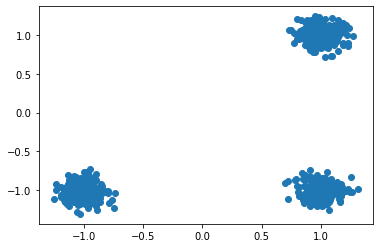

In [27]:
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler

centers = [[1, 1], [-1, -1], [1, -1]]
def my_init(X,n_clusters):
    centroids=np.array([[1, 1], [-1, -1], [1, -1]])
    return centroids
X1, labels_true = make_blobs(
    n_samples=750, centers=centers, cluster_std=0.1, random_state=0
)

X = StandardScaler().fit_transform(X1)

plt.scatter(X1[:, 0], X1[:, 1])
plt.show()